# Group Project: How do Song Statistics and Other Musical Elements Correlate to the Number of Spotify Streams?
#### Xuyang Chen, Rachel Weng, Martin Wong, Seabert Yuan
### Overview

Spotify is a digital music streaming service that allows users to access millions of songs on various devices, including computers, phones, and cars. As of 2024, Spotify is documented as the world’s most popular streaming service, with 350 million active users and 150 million premium subscribers. [(Source)](https://www.cnn.com/cnn-underscored/reviews/best-music-streaming-service#:~:text=Spotify%20is%20the%20most%20popular,users%20and%20150%20million%20subscribers.)

Our project aims to answer the following question: ***How do song statistics and other musical elements correlate to the number of Spotify streams?***

The dataset, from [(Kaggle)](https://www.kaggle.com/datasets/nelgiriyewithana/top-spotify-songs-2023/data), documents the most streamed Spotify songs globally of 2023 obtained using the Spotify API and provides an abundance of information about both the song’s background and musicality. A stream is defined as a user listening to a song for more than 30 seconds. The dataset also provides percentage values from a range of 0 - 100 % of danceability, defined as a track’s suitability for dancing based on musical factors such as tempo, beat strength, rhythmic stability, and overall regularity.

### Preliminary Exploratory Data Analysis

An exploration into the relationships between various variables and the number of Spotify streams will be expored to determine which variables should be used as predictors for our regression model. We begin by importing the necessary libraries.

In [1]:
library(tidyverse)
library(tidymodels)
library(reshape2)
library(repr)
options(repr.matrix.max.rows = 8)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

### Reading the Data from the web Into R

After uploading our onto github, it can be read using R's `read_csv()` function.

In [2]:
spotify_data <- read_csv("https://raw.githubusercontent.com/martin0wong/dsci100_project/main/data/spotify-2023.csv")
spotify_data

Rows: 953 Columns: 24
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (5): track_name, artist(s)_name, streams, key, mode
dbl (17): artist_count, released_year, released_month, released_day, in_spot...
num  (2): in_deezer_playlists, in_shazam_charts

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,⋯,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,⋯,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,⋯,125,B,Major,80,89,83,31,0,8,4
LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,⋯,92,C#,Major,71,61,74,7,0,10,4
vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,⋯,138,F,Major,51,32,53,17,0,31,6
Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,⋯,170,A,Major,55,58,72,11,0,11,15
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Bigger Than The Whole Sky,Taylor Swift,1,2022,10,21,1180,0,121871870,4,⋯,166,F#,Major,42,7,24,83,1,12,6
A Veces (feat. Feid),"Feid, Paulo Londra",2,2022,11,3,573,0,73513683,2,⋯,92,C#,Major,80,81,67,4,0,8,6
En La De Ella,"Feid, Sech, Jhayco",3,2022,10,20,1320,0,133895612,29,⋯,97,C#,Major,82,67,77,8,0,12,5
Alone,Burna Boy,1,2022,11,4,782,2,96007391,27,⋯,90,E,Minor,61,32,67,15,0,11,5


### Cleaning and Wrangling

Generally, the data is tidy. We can however, change the names of the columns for clarity and ensure that each column is using the right data type. Since the `released_` columns do not mean too much for us, we convert them into the number of days from the release day until December 31, 2023 inclusive. This value, calculated by using average days in a year and in a month, gives the number of days the song has been released for. We will then remove any observations that contain missing data as observations missing data may impact correlations within other variables. Finally, we will only select columns useful for visualization dropping columns such as the `track_name` or the `artist(s)_name`.

In [61]:
colnames(spotify_data) <- c("track_name", "artist(s)_name", "artist_count", "released_year", "released_month", "released_day", 
                                    "in_spotify_playlists", "in_spotify_charts", "streams", "in_apple_playlists", "in_apple_charts", 
                                    "in_deezer_playlists", "in_deezer_charts", "in_shazam_charts", "bpm", "key", "mode", 
                                    "danceability_percent", "valence_percent", "energy_percent", 
                                    "acousticness_percent", "instrumentalness_percent", "liveness_percent", "speechiness_percent")
spotify_data_wrangled <- spotify_data |>
                         mutate(key = as.factor(key)) |>
                         mutate(mode = as.factor(mode)) |>
                         #avg days in a year/month searched from web
                         mutate(days_released = round((2023-released_year)*365.25 + (12-released_month)*30.436875 + (30.436875-released_day), 0)) |>
                         mutate(across(streams:bpm, as.numeric)) |>
                         mutate(streams = streams/1000000) |>
                         drop_na() |>
                         #removing released_xxx columns as wrangled into days_released
                         select(track_name:artist_count, in_spotify_playlists:days_released)
spotify_data_wrangled

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `across(streams:bpm, as.numeric)`.
Caused by warning:
! NAs introduced by coercion”


track_name,artist(s)_name,artist_count,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,in_deezer_charts,⋯,key,mode,danceability_percent,valence_percent,energy_percent,acousticness_percent,instrumentalness_percent,liveness_percent,speechiness_percent,days_released
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,553,147,141.3817,43,263,45,10,⋯,B,Major,80,89,83,31,0,8,4,169
LALA,Myke Towers,1,1474,48,133.7163,48,126,58,14,⋯,C#,Major,71,61,74,7,0,10,4,281
vampire,Olivia Rodrigo,1,1397,113,140.0040,94,207,91,14,⋯,F,Major,51,32,53,17,0,31,6,183
Cruel Summer,Taylor Swift,1,7858,100,800.8408,116,207,125,12,⋯,A,Major,55,58,72,11,0,11,15,1590
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Bigger Than The Whole Sky,Taylor Swift,1,1180,0,121.87187,4,0,8,0,⋯,F#,Major,42,7,24,83,1,12,6,436
A Veces (feat. Feid),"Feid, Paulo Londra",2,573,0,73.51368,2,0,7,0,⋯,C#,Major,80,81,67,4,0,8,6,423
En La De Ella,"Feid, Sech, Jhayco",3,1320,0,133.89561,29,26,17,0,⋯,C#,Major,82,67,77,8,0,12,5,437
Alone,Burna Boy,1,782,2,96.00739,27,18,32,1,⋯,E,Minor,61,32,67,15,0,11,5,422


### Exploratory Data Analysis

First we set the seed for reproducibility. We will split the wrangled data such that 75% of the data will be used for training and the remaining 25% for testing. Then we summarize our data showing the average values for a certain bpm.

In [60]:
set.seed(15)
spotify_split <- initial_split(spotify_data_wrangled, prop = 0.75, strata = streams)
spotify_train <- training(spotify_split)
spotify_test <- testing(spotify_split)

spotify_summary <- merge(spotify_train |> group_by(bpm) |> summarize(across(in_spotify_playlists:in_apple_charts ,mean)),
                         spotify_train |> group_by(bpm) |> summarize(across(danceability_percent:days_released ,mean)))
spotify_summary <- merge(spotify_summary, spotify_train |> group_by(bpm) |> summarize(count = n()) |> arrange(bpm) |> select(bpm,count))
spotify_summary

bpm,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,danceability_percent,days_released,count
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
65,1127,0,110.84905,16,63,71,387,1
67,3408,47,518.74511,87,86,53,311,1
71,461,0,94.61649,7,11,59,667,1
72,1480,0,61.73984,1,0,56,596,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
198,3506,56,373.2000,105,64,59,394,1
202,8879,0,663.8321,182,107,24,21992,1
204,2420,19,429.8298,52,107,52,334,1
206,8448,23,882.8312,160,110,43,4382,1


With our training data, we can visualize how each predictor affects the number of Spotify streams.

In [28]:
spotify_charts <- spotify_train |>
                  select(in_spotify_charts, in_apple_charts, streams)
spotify_playlists <- spotify_train |>
                  select(in_spotify_playlists, in_apple_playlists, streams)
spotify_music <- spotify_train |>
                 select(bpm, days_released, danceability_percent, streams)

We first add the cowplot library to combine all plots with each column on the x-axis and the number of streams on Spotify on the y-axis to visualize how relevant certain variables are on the number of streams.

In [74]:
library(cowplot)

spotify_charts_plot <- spotify_charts |>
                        ggplot(aes(x= in_spotify_charts, y=streams)) +
                        labs(x = "Number of occurrences in Spotify charts", y = "Number of streams on Spotify (in million)") +
                        theme(text = element_text(size = 14)) +
                        geom_point(alpha = 0.25)
apple_charts_plot <- spotify_charts |>
                        ggplot(aes(x=in_apple_charts, y=streams)) +
                        labs(x = "Number of occurrences in Apple charts", y = "Number of streams on Spotify (in million)") +
                        theme(text = element_text(size = 14)) +
                        geom_point(alpha = 0.25)
charts_title <- ggdraw() + draw_label("Number of Spotify Streams Compared to Track Appearances on Various Platforms' Charts", fontface='bold')
charts_plots <- plot_grid(spotify_charts_plot, apple_charts_plot, ncol=2)
charts_plot <- plot_grid(charts_title, charts_plots, ncol=1, rel_heights=c(0.1, 1))

In [75]:
spotify_playlists_plot <- spotify_playlists |>
                        ggplot(aes(x=in_spotify_playlists, y=streams)) +
                        labs(x = "Number of occurrences in Spotify playlists", y = "Number of streams on Spotify (in million)") +
                        theme(text = element_text(size = 14)) +
                        geom_point(alpha = 0.25)
apple_playlists_plot <- spotify_playlists |>
                        ggplot(aes(x=in_apple_playlists, y=streams)) +
                        labs(x = "Number of occurrences in Apple playlists", y = "Number of streams on Spotify (in million)") +
                        theme(text = element_text(size = 14)) +
                        geom_point(alpha = 0.25)
playlists_title <- ggdraw() + draw_label("Number of Spotify Streams Compared to Track Appearances on Various Platforms' Playlists", fontface='bold')
playlists_plots <- plot_grid(spotify_playlists_plot, apple_playlists_plot, ncol=2)
playlists_plot <- plot_grid(playlists_title, playlists_plots, ncol=1, rel_heights=c(0.1, 1))

In [76]:
bpm_plot <- spotify_music |>
                        ggplot(aes(x=bpm, y=streams)) +
                        labs(x = "Track's Beats per Minute (BPM)", y = "Number of streams on Spotify (in million)") +
                        theme(text = element_text(size = 14)) +
                        geom_point(alpha = 0.25)
released_plot <- spotify_music |>
                        ggplot(aes(x=days_released, y=streams)) +
                        labs(x = "Days Since Release", y = "Number of streams on Spotify (in million)") +
                        theme(text = element_text(size = 14)) +
                        geom_point(alpha = 0.25)
danceability_plot <- spotify_music |>
                        ggplot(aes(x=danceability_percent, y=streams)) +
                        labs(x = "Percent Describing the Track's Danceability (%)", y = "Number of streams on Spotify (in million)") +
                        theme(text = element_text(size = 14)) +
                        geom_point(alpha = 0.25)
track_title <- ggdraw() + draw_label("Number of Spotify Streams Compared to Track's Various Properties", fontface='bold')
track_plots <- plot_grid(bpm_plot, released_plot, danceability_plot, ncol=3)
track_plot <- plot_grid(track_title, track_plots, ncol=1, rel_heights=c(0.1, 1))

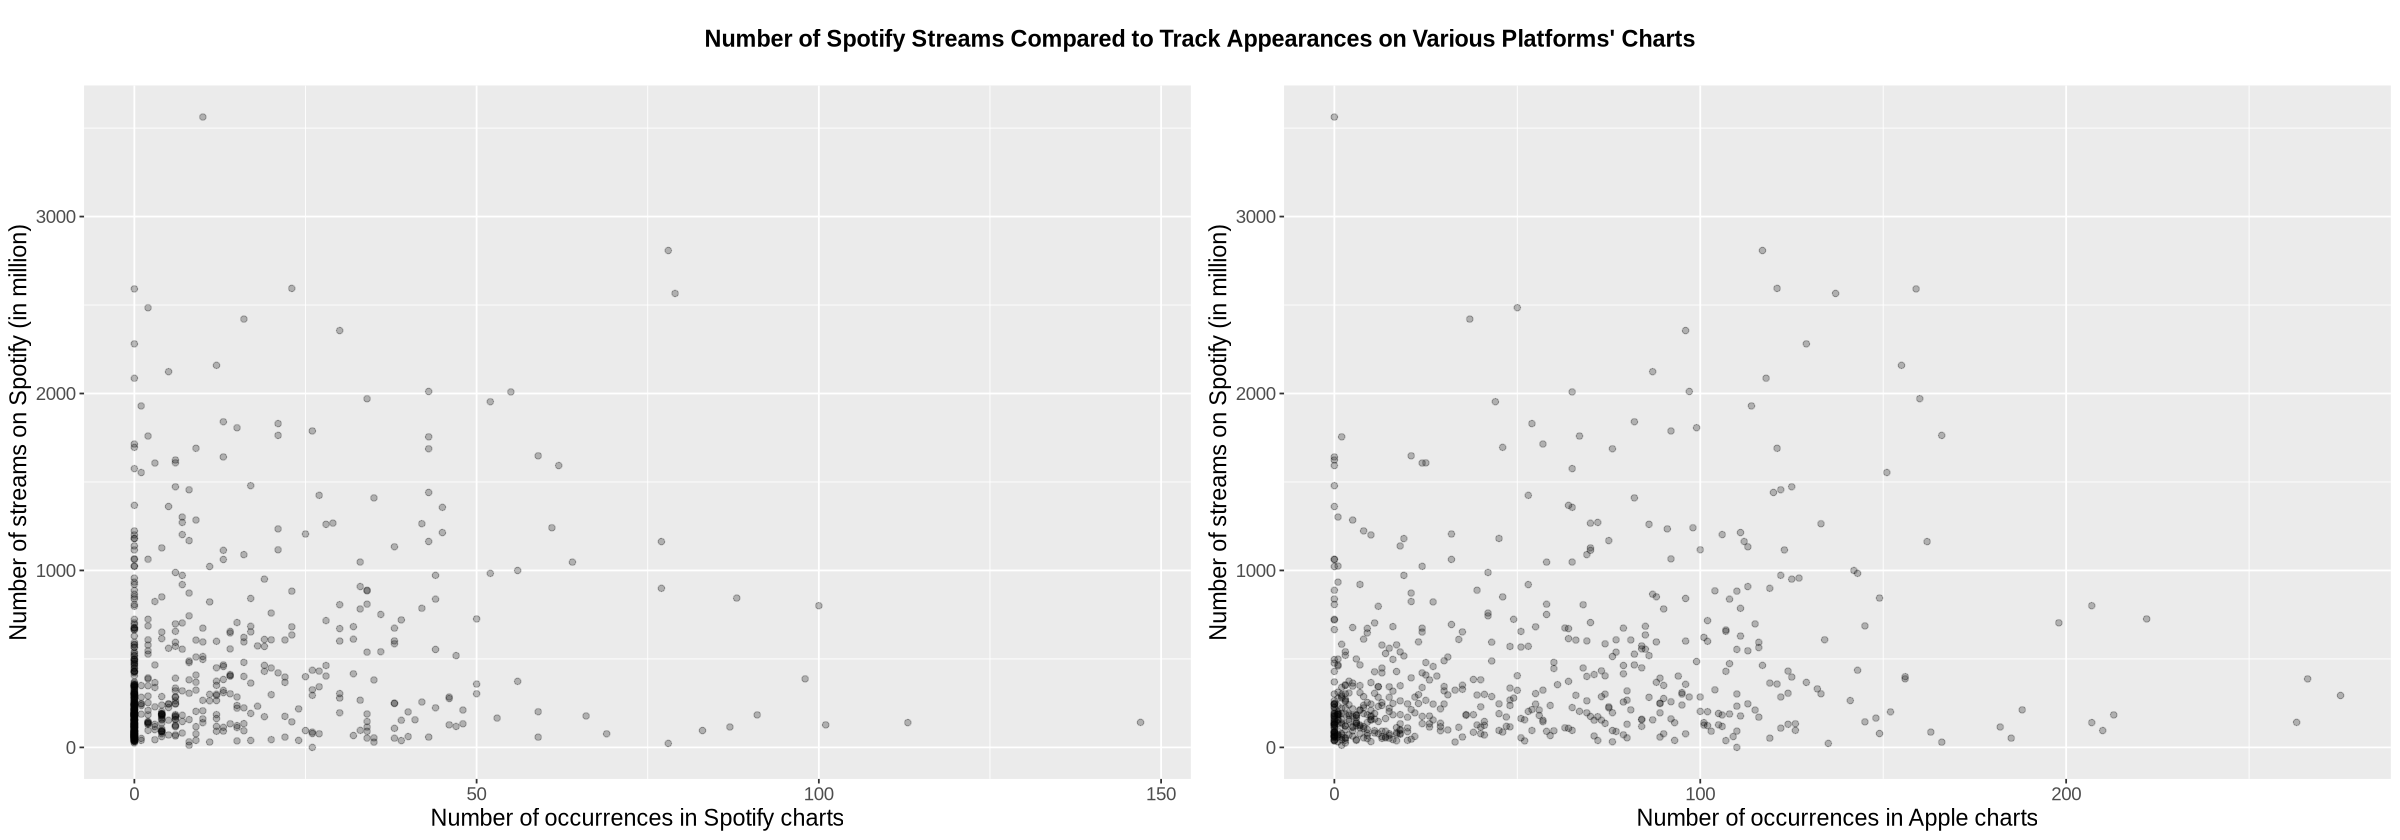

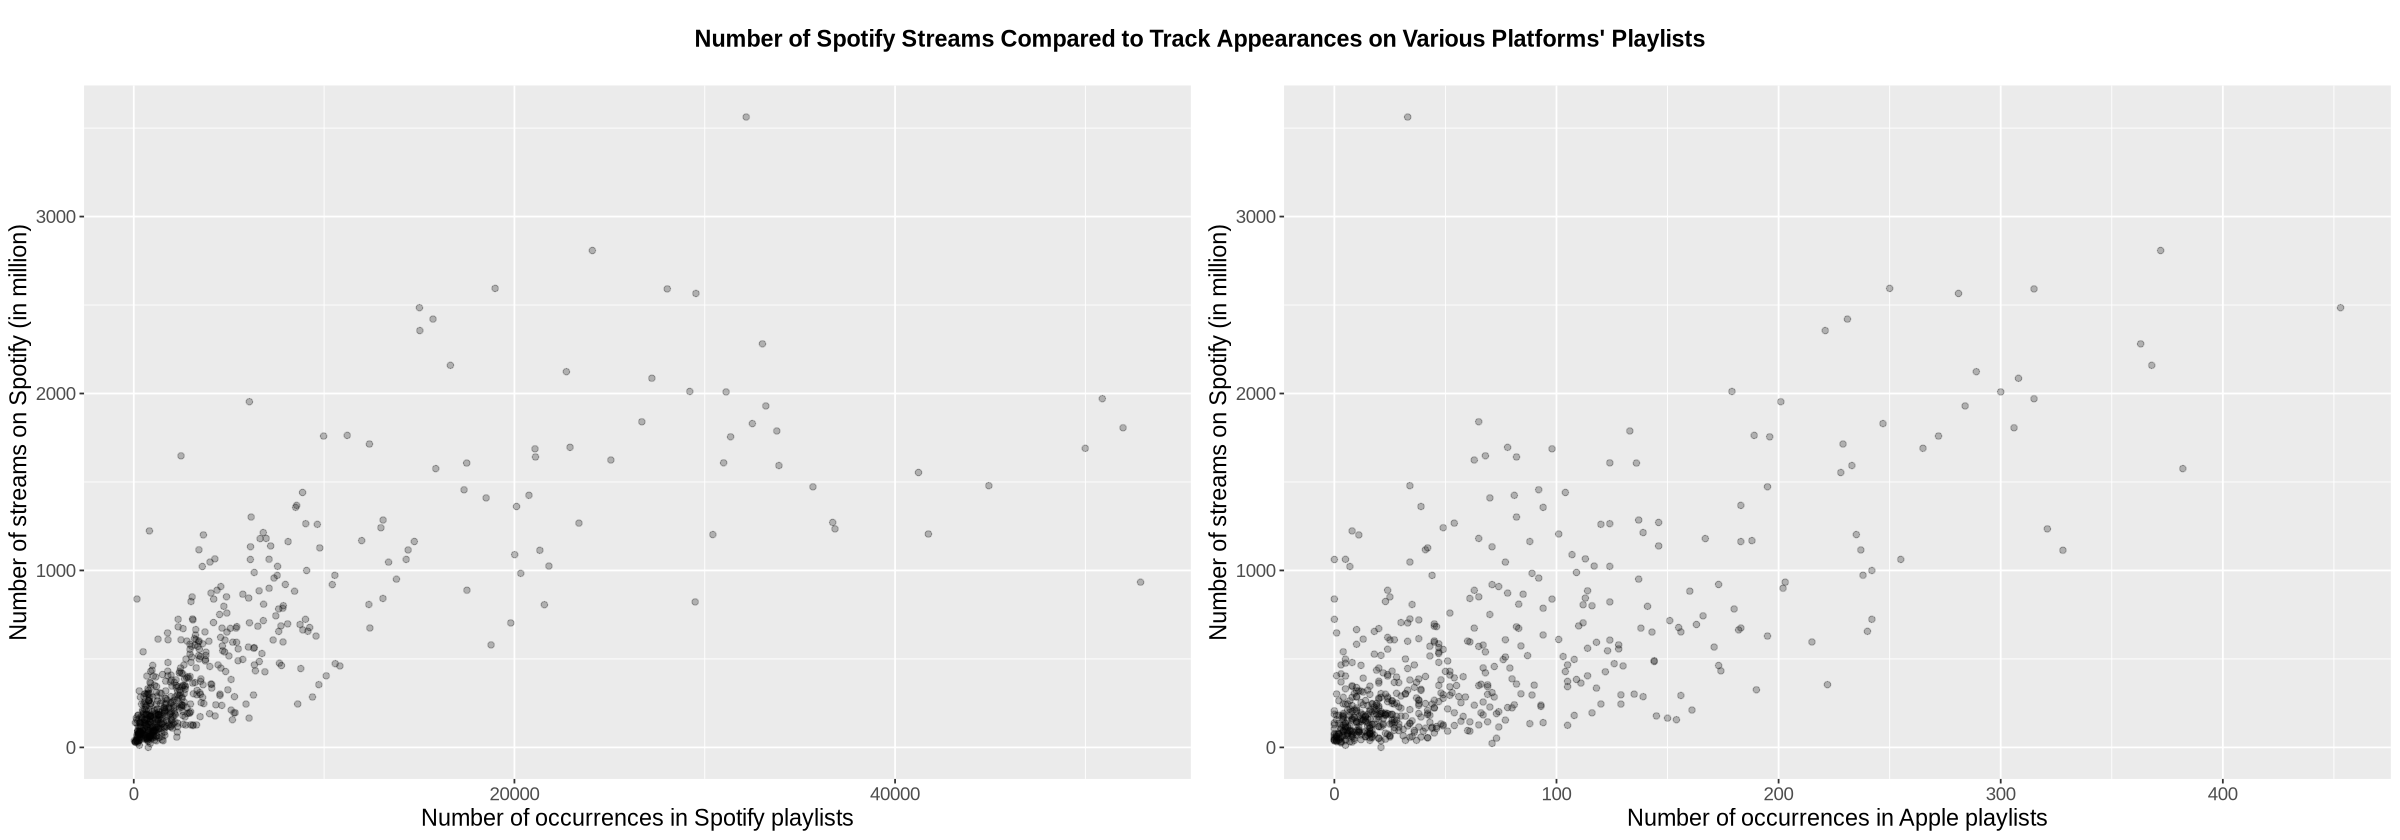

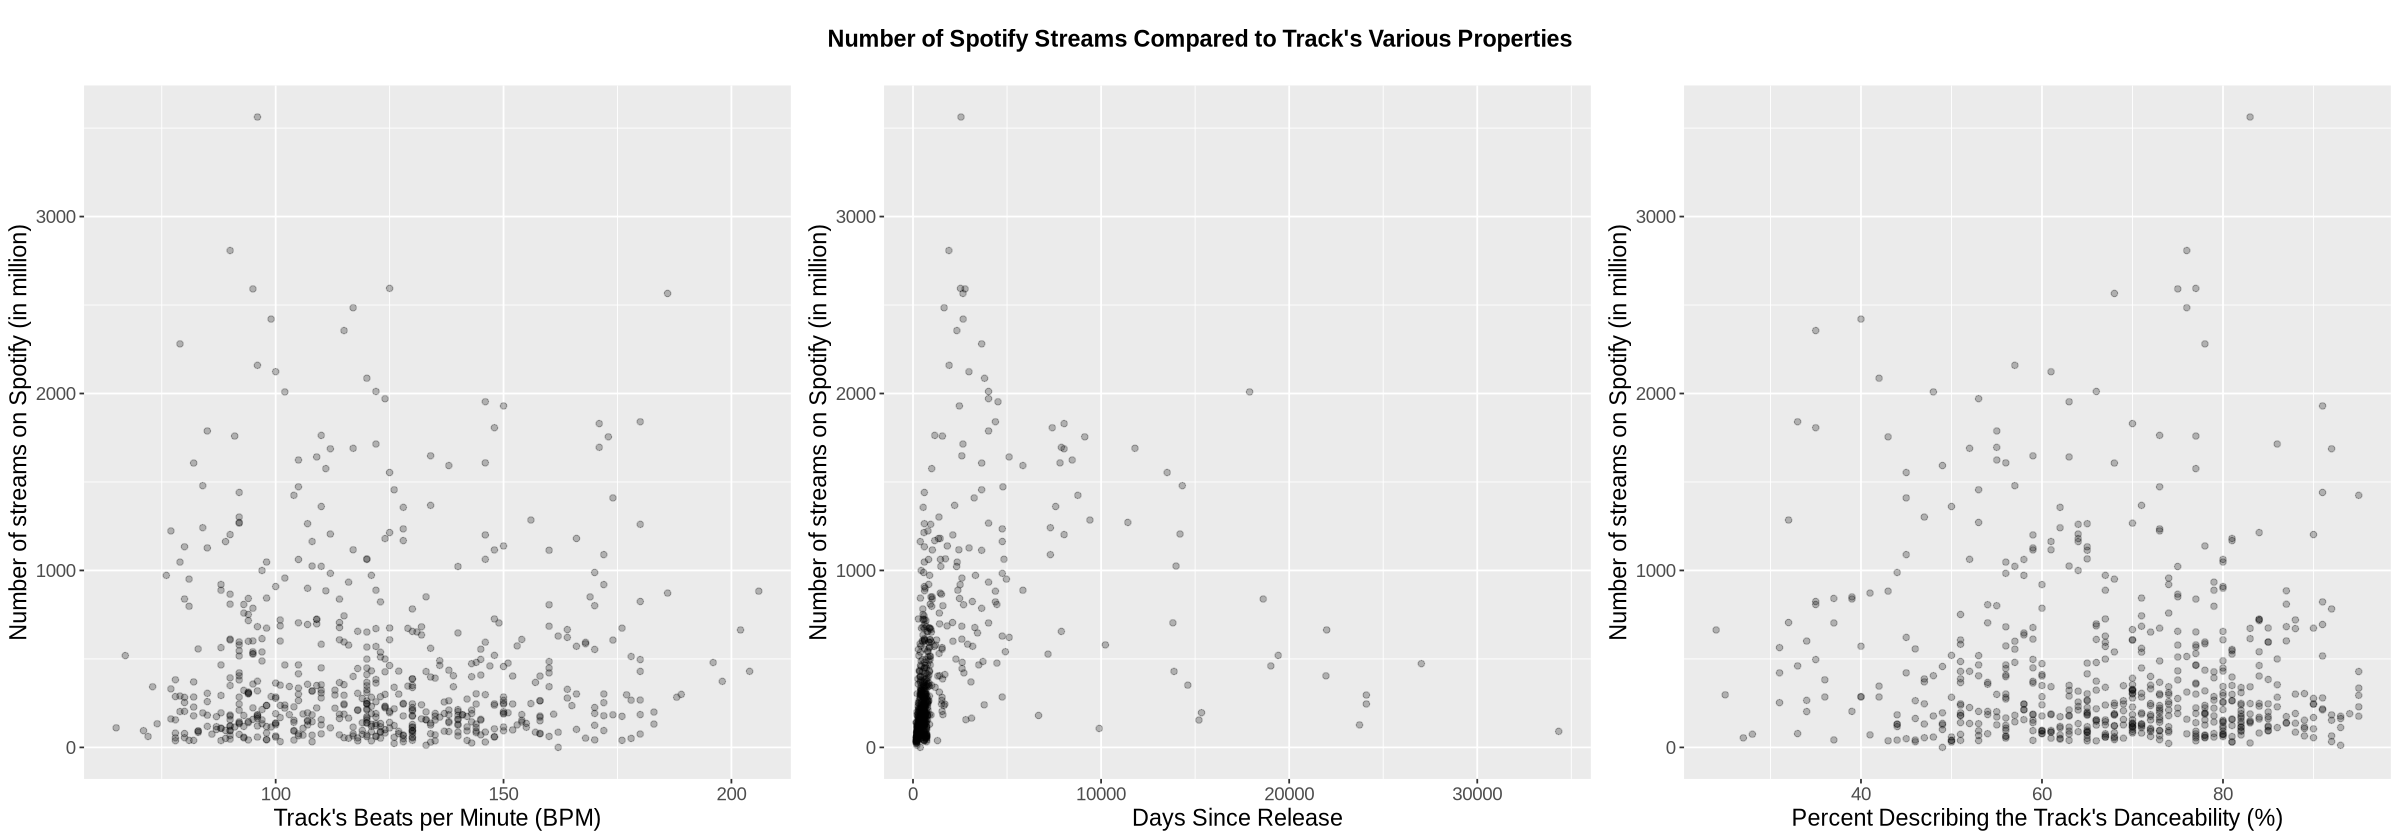

In [77]:
options(repr.plot.height = 7, repr.plot.width = 20)
charts_plot
playlists_plot
track_plot

### Methods:

To conduct the data analysis, we will use K-NN regression because certain variables such as beats-per-minute, danceability, and release days have more of a parabolic relationship; however, if it is determined that K-NN cannot perform well with a large number of predictors, we will use linear regression.

Upon conducting preliminary exploratory data analysis, we will use the following variables as predictors for the number of streams. These were chosen as predictors because they are all measured numerically as opposed to categorically, have unambiguous definitions, and show some sort of relationship with the number of streams.

- Number of occurrences in Spotify charts
- Number of occurrences in Apple charts
- Number of occurrences in Spotify playlists
- Number of occurrences in Apple playlists
- Track beats per minute
- Days since release
- Danceability (%)

For K-NN, we will visualize the results by creating a scatter plot and plotting the predictors (song’s statistics) against the number of streams, while also drawing the root mean square prediction error line on the plot. For linear regression, we will do the same and add its predicted regression line.

### Expected outcomes and significance:

Based on the exploratory analysis and previous trends, we expect to find songs with moderately high bpm (90-150), high danceability (> 50%), and songs released for between 1000 and 3000 days to correlate with an increased number of streams. We also expect to find a positive relationship between all the number of occurrences variables and the number of streams.

By finding trends in songs people enjoy and connect to, we can study the emotional and cultural effects of music on society and how it shapes mood, shifts perceptions, and sparks motivation and inspiration. Our findings can also help artists create popular songs and improve streaming services by helping streaming platforms recommend songs to users. Moreover, these findings may be valuable to historians who would like to compare the evolution of music through the 21st century.

Further questions from the data analysis include:
- How might the musical attributes of the most streamed songs shift over time?
- Why do people generally enjoy faster songs?